<a href="https://colab.research.google.com/github/amr-elbana/AI-driven-post-harvest-sorting-system/blob/main/classification-Models/Augmented_Dataset_Models/Vgg19_Orange_Classification_Healthy_vs_Rotten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
!cp -r "/content/drive/MyDrive/Dataset/Splitted dataset" /content/data

In [ ]:
dataset_base_path = "/content/data"  # Store the base path
model_save_path = "/content/drive/MyDrive/Graduation Project/Trained Models/VGG19_Model/_FineTuning_VGG19_5_layers_more epochs"
final_model_path = os.path.join(model_save_path, "Fine_Tuning_vgg19_best_model.keras")
history_file_path = os.path.join(model_save_path, "training_history.json")
results_save_path = os.path.join(model_save_path, "orange_vgg19_results.txt")
conf_matrix_save_path = os.path.join(model_save_path, "orange_vgg19_confusion_matrix.png")

In [ ]:
# Define paths and constants
data_dir = os.path.join(dataset_base_path, "train-2")
val_dir = os.path.join(dataset_base_path, "validation")
test_dir = os.path.join(dataset_base_path, "test")
batch_size = 32
target_size = (224, 224)
epochs = 30

In [ ]:
# Create an ImageDataGenerator with VGG19 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG19-specific preprocessing
    validation_split=0.2,  # Use 20% of data for validation
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Randomly apply shearing transformations
    zoom_range=0.2,         # Randomly zoom in or out on images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill in missing pixels using the nearest neighbor
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to VGG19 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='training',            # Use 80% of data for training
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to VGG19 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='validation',          # Use 20% of data for validation
    shuffle=False                 # No need to shuffle validation data
)

# ... (rest of the code remains the same)

# Check the number of samples in each generator
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(validation_generator)}")

Found 5096 images belonging to 2 classes.
Found 1272 images belonging to 2 classes.
Training samples: 5096
Validation samples: 1272
Training batches per epoch: 160
Validation batches per epoch: 40


In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for VGG19 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # VGG19-specific preprocessing
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # VGG19 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")


Found 373 images belonging to 2 classes.
Test samples: 373
Test batches: 12


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

def create_model():
    # Load VGG19 model with pretrained weights, excluding the top (fully connected) layers
    vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg19_base.trainable = False  # Freeze all layers initially

   # Add custom layers
    inputs = layers.Input(shape=(224, 224, 3))
    x = vgg19_base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    # Compile model
    optimizer = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    model.summary()
    return model



## Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
# checkpoint_path = "/content/drive/MyDrive/Models/overfit_vgg19_{epoch:02d}-{val_accuracy:0.2f}.keras"
checkpoint_path = os.path.join(model_save_path, "vgg19_{epoch:02d}-{val_accuracy:0.2f}-{val_loss:.4f}.keras")

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Save the best model based on validation accuracy
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Adjust learning rate if validation loss doesn't improve
    factor=0.5,          # Reduce learning rate by a factor of 5
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-6,         # Set a minimum learning rate
    verbose=0
)

model = create_model()

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,  # Set a sufficiently high number; EarlyStopping will handle stopping
    callbacks=[checkpoint, early_stopping_monitor, reduce_lr]
)
# Save the final best model
model.save(final_model_path)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,223,809 (77.15 MB)

 Trainable params: 198,401 (775.00 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.7770 - loss: 1.0753
Epoch 1: val_accuracy improved from -inf to 0.92610, saving model to /content/drive/MyDrive/Graduation Project/Trained Models/VGG19_Model/_FineTuning_VGG19_5_layers_more epochs/vgg19_01-0.93-0.7674.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.7775 - loss: 1.0745 - val_accuracy: 0.9261 - val_loss: 0.7674 - learning_rate: 0.0010
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9208 - loss: 0.8068
Epoch 2: val_accuracy improved from 0.92610 to 0.94340, saving model to /content/drive/MyDrive/Graduation Project/Trained Models/VGG19_Model/_FineTuning_VGG19_5_layers_more epochs/vgg19_02-0.94-0.7292.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 160s 932ms/step - accuracy: 0.9208 - loss: 0.8068 - val_accuracy: 0.9434 - val_loss: 0.7292 - learning_rate: 0.0010
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9254 - loss: 0.7764
Epoch 3: val_accuracy improved from 0.94340 to 0.

# HISTORY PLOTTING


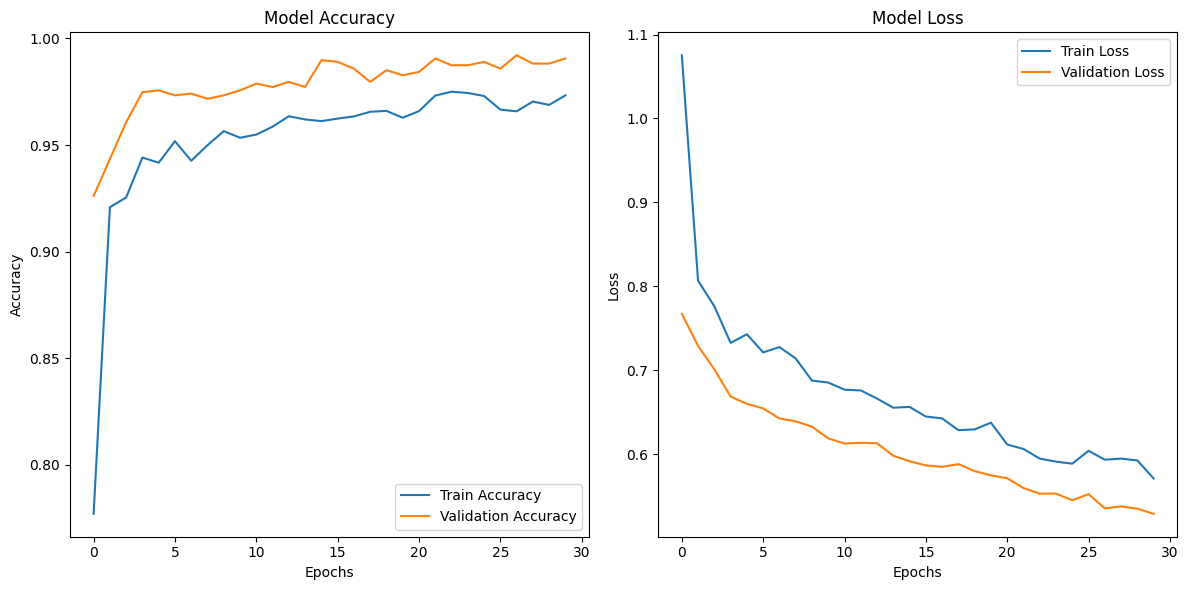

Plot saved to: /content/drive/MyDrive/Graduation Project 24 25/Trained Models/VGG19_Model/training_plot.png


In [7]:
import json
import matplotlib.pyplot as plt

# Load the training history from the JSON file
json_file_path = '/content/drive/MyDrive/Graduation Project 24 25/Trained Models/VGG19_Model/_FineTuning_VGG19_5_layers_more epochs/training_history.json'
with open(json_file_path, 'r') as f:
    history = json.load(f)

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

# Save the plot to a file
plot_save_path = '/content/drive/MyDrive/Graduation Project 24 25/Trained Models/VGG19_Model/training_plot.png'
plt.savefig(plot_save_path)
plt.show()

print(f"Plot saved to: {plot_save_path}")

Model Evaluation Using Test Data

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
model = tf.keras.models.load_model(final_model_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Healthy', 'Rotten'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 180s 15s/step
Confusion Matrix:
 [[185   0]
 [  5 183]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.97      1.00      0.99       185
      Rotten       1.00      0.97      0.99       188

    accuracy                           0.99       373
   macro avg       0.99      0.99      0.99       373
weighted avg       0.99      0.99      0.99       373


Accuracy: 0.9865951742627346

F1 Score: 0.9865229110512129


In [ ]:
# Define where to save everything
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/Graduation Project/Trained Models/VGG19_Model/_FineTuning_VGG19_5_layers_more epochs/orange_vgg19_results.txt


In [ ]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Rotten"], yticklabels=["Healthy", "Rotten"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/Graduation Project/Trained Models/VGG19_Model/_FineTuning_VGG19_5_layers_more epochs/orange_vgg19_confusion_matrix.png
